![imagem](http://lapix.ufsc.br/wp-content/uploads/2022/09/NB-banner-PT.jpg)


# 15.1.1.Notebook para Segmentação Semântica - ResNet50 + U-Net (PyTorch)
#### Novembro de 2024

### Autores:

* Aldo von Wangenheim: aldo.vw@ufsc.br [Review, Maintainer]
* Luiz Antonio Buschetto Macarini: luiz.buschetto@posgrad.ufsc.br [Dataset]
* Thiago Zimmermann Loureiro Chaves: thiago.zlc@grad.ufsc.br [Dataset]
* Rodrigo de Paula e Silva Ribeiro: ribeiro.rodrigo@posgrad.ufsc.br [Review, Code, Maintainer]

<a href="https://colab.research.google.com/github/awangenh/vision/blob/master/jupyter/15.1.1.Segmenta%C3%A7%C3%A3o%20Sem%C3%A2ntica-U-Net_Resnet.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="https://img.shields.io/badge/python-3.10-greeng" alt="Python Version" title="Python Version"></a>

### Verificando a Placa de Vídeo executando

Obs: Para utilizar uma placa de vídeo no colab:


1) Clique no ▾ do lado do conectar

2) Ver recursos

3) Alterar o tipo de ambiente de execução

4) Acelerador de hardware: GPU

SE ESTIVER UTILIZANDO NO LAPIX DEFINIR A GPU A SER UTILIZADA NO CÓDIGO ABAIXO

In [ ]:
!nvcc --version

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False
    %reload_ext autoreload
    %autoreload 2
    %matplotlib inline
    from IPython import get_ipython
    
print('Running on Google Colab = ', _ON_COLAB)
import os
import torch

# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
else:
    BASE_PATH = "/lapix" # trocar para o base path do seu computador se estiver rodando localmente, deixar /lapix se estiver rodando nos conteiners lapix
    VISIBLE_GPUS = [7] # Selecionar a GPU PARA RODAR! VER QUAL ESTA LIVRE

    if torch.cuda.device_count() != 8:
        print("GPU SETADA - PULANDO ETAPA")
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        print("CUDA GPUS NUMBER: ", torch.cuda.device_count())
    
os.chdir(BASE_PATH) # garantir que está executando no caminho base definido

# Suprimir Avisos Gerais na saida do notebook
Suprimir apenas "avisos", erros irá mostrar a causar e efetuará a parada do notebook normalmente.

In [ ]:

import warnings
warnings.filterwarnings('ignore')


# Instalação e verificação das bibliotecas

Instalação das bibliotecas necessárias para rodar e avaliar o modelo implementado neste notebook.

In [ ]:
INSTALL_LIBS = False # Setar para True para instalar localmente também (Não é necessário se estiver rodando nos conteiners Lapix)

if _ON_COLAB:
    INSTALL_LIBS = True

if INSTALL_LIBS:
    !pip install lapixdl
    !pip install -U albumentations
    !pip install fastai
    !pip install wandb -qU

# OPCIONAL: Utilizar WandB
*   Software para visualizar métricas e compara-los entre experimentos.
*   https://wandb.ai/site
*   Obs: Necessário criar uma conta e gerar um token de acesso.

CASO NÃO QUEIRA USAR WANDB, NÃO EXECUTE ESTA CELULA. IRÁ TRAVAR O PROCESSO ATÉ SER INSERIDO UMA CHAVE VÁLIDA.


In [ ]:
# Log in to your W&B account
import wandb
wandb.login()
!wandb enabled

# OPCIONAL: Montando o Google Drive
Para salvar no google drive execute a celula abaixo para montar o drive e atualize os caminhos de salvamento dos notebook.

In [ ]:
from google.colab import drive
DRIVE_PATH = os.path.join(BASE_PATH, "gdrive")
drive.mount(DRIVE_PATH)

# Carregar as bibliotecas
Realiza o import das bibliotecas básicas do notebook

In [ ]:
from pathlib import Path
import fnmatch
import random
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from fastai.vision.all import *
from fastai.callback.wandb import *


import cv2

from lapixdl.evaluation.visualize import show_segmentations
from lapixdl.evaluation.model import Result, Mask


# Importar Road Traversing Knowledge (RTK) Dataset

Este conjunto de dados contém estradas com diferentes tipos de superfície: variações de asfalto, outros tipos de pavimento e até estradas não pavimentadas. Contém também situações com danos na estrada (ex.: buracos). As imagens foram capturadas em um veículo em movimento nas cidades de Águas Mornas e Santo Amaro da Imperatriz, vizinhas de Florianópolis, no estado de Santa Catarina, Brasil. Também fazemos grande parte dos quadros separados por suas classes, como dados de teste.



## Tipos de Estrada:




*   Background, everything being unrelated to the road surface;
*   Asphalt, roads with asphalt surface;
*   Paved, different pavements (eg.: Cobblestone);
*   Unpaved, for unpaved roads;
*   Markings, to the road markings;
*   Speed-Bump, for the speed-bumps on the road;
*   Cats-Eye, for the cats-eye found on the road, both on the side and in the center of the path;
*   Storm-Drain, usually at the side edges of the road;
*   Patch, for the various patches found on asphalt road;
*   Water-Puddle, we use this class also for muddy regions;
*   Pothole, for different types and sizes of potholes, no matter if they are on asphalt, paved or unpaved roads;
*   Cracks, used in different road damages, like ruptures.

In [ ]:
import os
# Download do dataset RTK pelo Mendeley
file_link = "https://data.mendeley.com/public-files/datasets/hssswvmjwf/files/2c72e75d-1f50-457a-86f0-a5e3a4174df9/file_downloaded"
!wget $file_link

os.rename(os.path.join(BASE_PATH, "file_downloaded"), os.path.join(BASE_PATH, "file_downloaded.zip"))
!unzip -qq -u file_downloaded.zip
!rm file_downloaded.zip

# Selecionamos a Rede Neural


*   resnet18, resnet34, resnet50, resnet101, resnet152
*   squeezenet1_0, squeezenet1_1
*   densenet121, densenet169, densenet201, densenet161
*   vgg16_bn, vgg19_bn
*   alexnet

Obs: Temos que alterar o import e o used model

# Resnet

ResNet é um modelo proposto em 2015 por pesquisadores da Microsoft Research que introduziu uma nova arquitetura chamada Rede Residual.

Para resolver o problema do vanishing/exploding gradient, esta arquitetura introduziu o conceito denominado Blocos Residuais. Nesta rede, usamos uma técnica chamada de skip conections. A skip connection conecta as ativações de uma camada a outras camadas, pulando algumas camadas entre elas. Isso forma um bloco residual. Resnets são feitas empilhando esses blocos residuais juntos.
A abordagem por trás dessa rede é, em vez de camadas aprenderem o mapeamento subjacente, permitimos que a rede se ajuste ao mapeamento residual

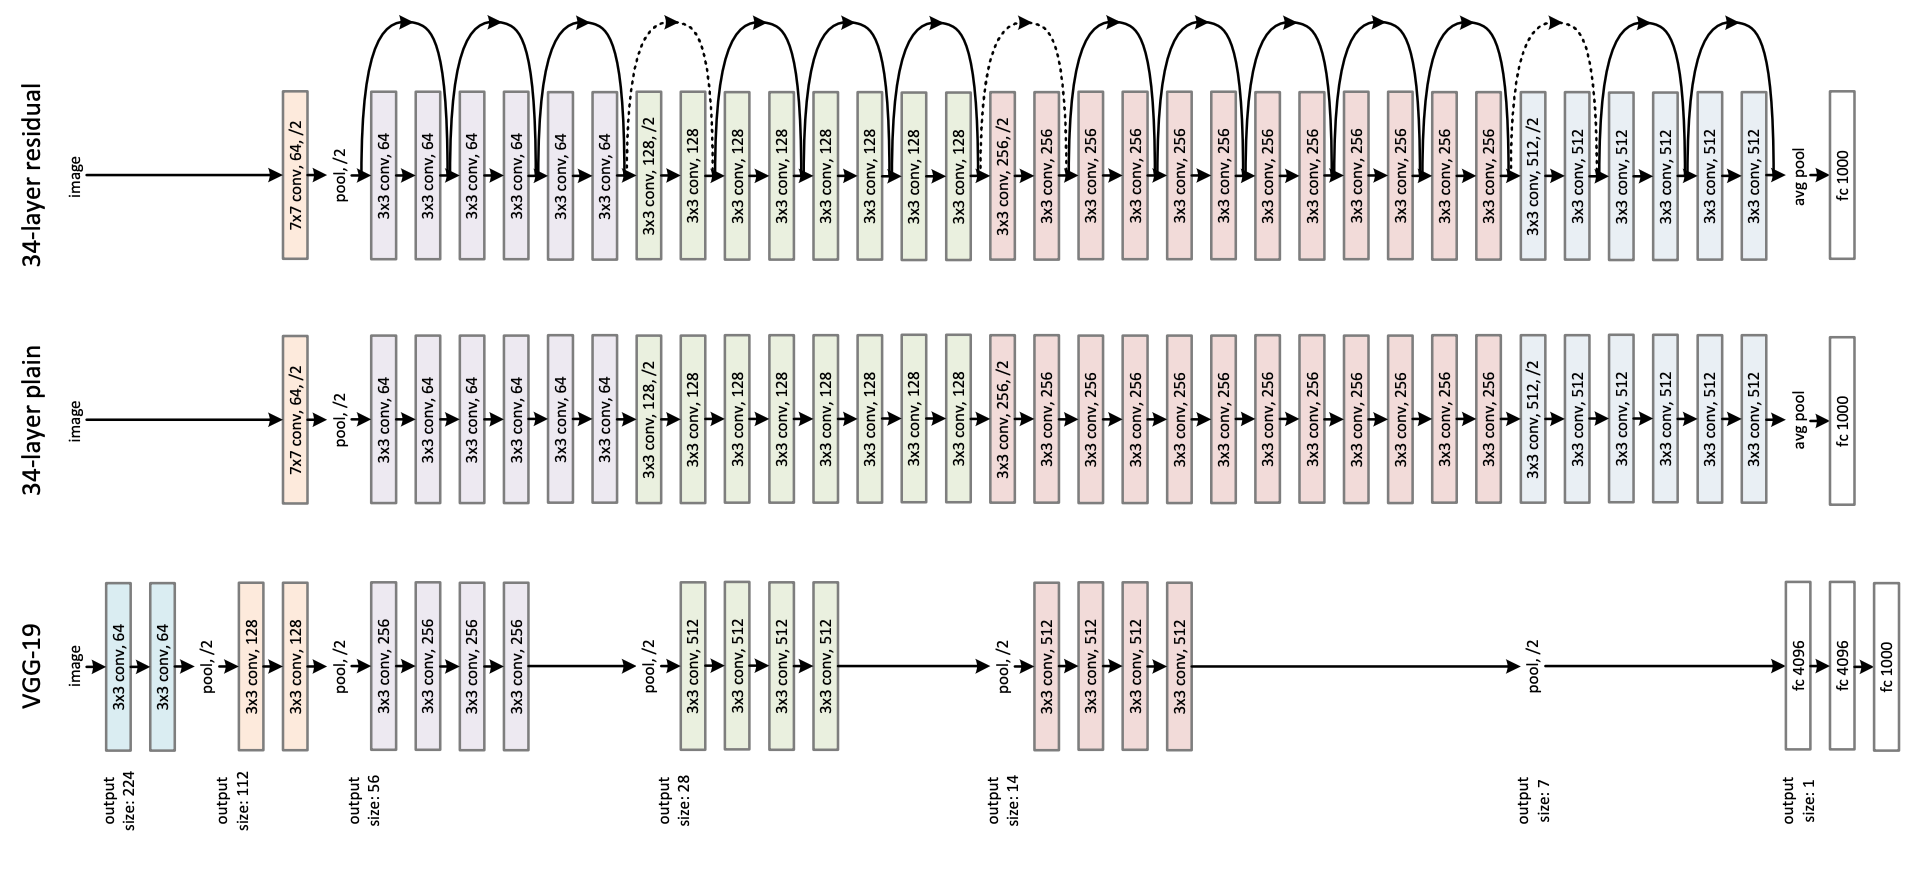



In [ ]:
# Definir o modelo de backbone ResNet
from fastai.vision.models import resnet18, resnet34, resnet50
used_model = resnet34

In [ ]:
# Montagem do google drive (opcional)
from google.colab import drive
drive.mount('/content/gdrive')


In [ ]:
dataset_root = os.path.join(BASE_PATH, 'RTK') # caminho base do dataset
OUTPUT_DIR = os.path.join(BASE_PATH, 'output') # pasta onde será salvo as saidas do modelo
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Dividindo o Dataset em Conjunto Train,Valid e Teste

In [ ]:
# Dividir conjunto de treino
def train_test_split():
    print("########### Train Test Val Script started ###########")

    src = os.path.join(dataset_root, "image")
    root_dir = os.path.join(dataset_root, "imagesSplitted")
    

    val_ratio = 0.10
    test_ratio = 0.10

    allFileNames = os.listdir(src)
    np.random.seed(2)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),[int(len(allFileNames) * (1 - (val_ratio + test_ratio))),int(len(allFileNames) * (1 - val_ratio)),])
    train_FileNames = [os.path.join(src, name) for name in train_FileNames.tolist()]
    val_FileNames = [os.path.join(src, name) for name in val_FileNames.tolist()]
    test_FileNames = [os.path.join(src, name) for name in test_FileNames.tolist()]

    print('Total images: '+ str(len(allFileNames)))
    print('Training: '+ str(len(train_FileNames)))
    print('Validation: '+  str(len(val_FileNames)))
    print('Testing: '+ str(len(test_FileNames)))

    # # Creating Train / Val / Test folders (One time use)
    TRAIN_DIR = os.path.join(root_dir, 'train')
    os.makedirs(TRAIN_DIR)
    VAL_DIR = os.path.join(root_dir, 'val')
    os.makedirs(VAL_DIR)
    TEST_DIR = os.path.join(root_dir, 'test')
    os.makedirs(TEST_DIR)

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, TRAIN_DIR)

    for name in val_FileNames:
        shutil.copy(name, VAL_DIR)

    for name in test_FileNames:
        shutil.copy(name, TEST_DIR)

train_test_split()

print("########### Train Test Val Script Ended ###########")

# Definindo os paths das imagens

Setamos o path do dataset, imagens e o output, onde ficarão os modelos treinados.

In [ ]:
path_lbl = os.path.join(dataset_root,'label') # Path das mascaras
path_img = os.path.join(dataset_root, 'imagesSplitted') # Path do split train/test/val das imagens
path_models = OUTPUT_DIR # Path do Output
lbl_names = get_image_files(path_lbl)
len(lbl_names)

In [ ]:
fnames = get_image_files(path_img, folders=['train', 'val'])

get_mask = lambda x: os.path.join(path_lbl, f'{x.stem}{x.suffix}')
mask = PILMask.create(get_mask(fnames[1]))
src_size = np.array(mask.shape)
src_size

# Setando os labels
Criamos esse txt com os labels afim de fazer a legenda para imagens demonstrando o resultados.

In [ ]:
config_file_content = '''background
roadAsphalt
roadPaved
roadUnpaved
roadMarking
speedBump
catsEye
stormDrain
manholeCover
patchs
waterPuddle
pothole
craks

'''

codes_save_path = os.path.join(BASE_PATH, "codes.txt")

f = open(codes_save_path, "w")
f.write(config_file_content)
f.close()

In [ ]:
codes = np.loadtxt(codes_save_path, dtype=str)
codes[0] = 'background' # To show in the visualization
codes

# Metrics, augmentations, data split and model definition

## Resize e Augmentations

*   Flip Vertical e Horizontal
*   Rotacionamento e Zoom



In [ ]:
# Fix seed
import random
import albumentations as A
random.seed(81615)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0 #Train only
    order = 2 #After resize
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

class ImageResizer(Transform):
    order=1
    "Resize image to `size` using `resample`"
    def __init__(self, size, resample=Image.BILINEAR):
        if not is_listy(size): size=(size,size)
        self.size,self.resample = (size[1],size[0]),resample

    def encodes(self, o:PILImage): return o.resize(size=self.size, resample=self.resample)
    def encodes(self, o:PILMask):  return o.resize(size=self.size, resample=Image.NEAREST)

zoom_augmentation = lambda img_shape: A.Compose([
    A.RandomScale(scale_limit=(0, 0.1), p=0.75),
    A.CenterCrop(img_shape[0], img_shape[1])
])

augmentations = lambda img_shape: A.Compose([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate((-10, 10), p=0.75),
    zoom_augmentation(img_shape),
    # A.RandomBrightnessContrast(0.1, 0.1, p=0.75),
    A.Affine(p=0.75, shear=0.2)
])

In [ ]:
tfms = [[PILImage.create], [get_mask, PILMask.create, AddMaskCodes(codes)]]
folder_split = FuncSplitter(lambda fname: Path(fname).parent.name == 'val')
src = Datasets(fnames, tfms, splits=folder_split(fnames))

# Metricas para avaliação
## Jaccard index (IoU)

O coeficiente de Jaccard mede a similaridade entre conjuntos de amostras finitas e é definido como o tamanho da interseção dividido pelo tamanho da união dos conjuntos de amostras.

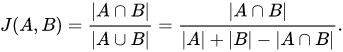

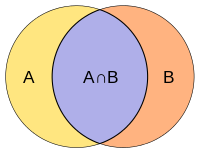

In [ ]:
class DiceMulti(Metric):
    "Averaged Dice metric (Macro F1) for multiclass target in segmentation"
    def __init__(self, axis=1): self.axis = axis
    def reset(self): self.inter,self.union,self.total_area = {},{},{}
    def accumulate(self, learn):
        pred,targ = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
        for c in range(learn.pred.shape[self.axis]):
            p = torch.where(pred == c, 1, 0)
            t = torch.where(targ == c, 1, 0)
            c_inter = (p*t).float().sum().item()
            c_totalSumAreas = (p+t).float().sum().item()
            c_union = c_totalSumAreas-c_inter
            if c in self.inter:
                self.inter[c] += c_inter
                self.total_area[c] += c_totalSumAreas
                self.union[c] += c_union
            else:
                self.inter[c] = c_inter
                self.total_area[c] = c_totalSumAreas
                self.union[c] = c_union
    @property
    def value(self):
        binary_dice_scores = np.array([])
        for c in self.inter:
            binary_dice_scores = np.append(binary_dice_scores, 2.*self.inter[c]/self.total_area[c] if self.total_area[c] > 0 else np.nan)
        return np.nanmean(binary_dice_scores)

class JaccardCoeffMulti(DiceMulti):
  "Implementation of the Averaged Jaccard coefficient that is lighter in RAM -- Mean IoU (Intersection Over Union)"
  @property
  def value(self):
    binary_jaccard_scores = np.array([])
    for c in self.inter:
        binary_jaccard_scores = np.append(binary_jaccard_scores, self.inter[c]/self.union[c] if self.union[c] > 0 else np.nan)
    return np.nanmean(binary_jaccard_scores)

def acc_metric(ipt, target):
  return foreground_acc(ipt, target, bkg_idx=0)

iou_metric = JaccardCoeffMulti()

f1_metric = DiceMulti()

metrics = [acc_metric, iou_metric, f1_metric]

# Apresenta os resultados (N = número de imagens selecionadas)
Função retorna a imagem, máscara original e a máscara prevista. Além disso armazena o nome da imagem para o display posterior.

In [ ]:
names = []
def get_results(predict, size, n=3):
  for fname in random.sample(fnames, n):
    res = predict(fname)
    names.append(fname)
    yield Result(
        np.array(PILImage.create(fname).resize((size[1], size[0]))),
        np.array(PILMask.create(get_mask(fname)).resize((size[1], size[0]))),
        np.array(res[0]),
    )

# Lapixdl function

Aqui usamos, com leves ajustes para este experimento, um função de nossa biblioteca *LAPiX DL - Utils for Computer Vision Deep Learning research* disponível em:

* https://github.com/lapix-ufsc/lapixdl

In [ ]:
from __future__ import annotations

import math
from typing import Union

import matplotlib.patches as mpatches
import seaborn as sn
from matplotlib import cm
from matplotlib.axes import Axes
from matplotlib.colors import Colormap
from matplotlib.figure import Figure

def rename(name):
  fname = str(path_img)
  fname_s = str(name)
  if fname_s[len(fname)+1:][0] == "t":
    return fname_s[len(fname)+7:]
  else:
    return fname_s[len(fname)+5:]

correct_color = sn.color_palette('Paired')[3]
incorrect_color = sn.color_palette('Paired')[5]

ColorMap = Union[str, Colormap]

def show_segmentations_dif(
        results: list[Result[Mask]],
        class_names: list[str],
        cmap: ColorMap = 'tab20',
        num_imgs: int = 3,
        figSize: list[int] = [15,60],
        mask_alpha: float = .3) -> tuple[Figure, Axes]:

    cmap_colors = cm.get_cmap(cmap).colors

    assert len(cmap_colors) >= len(
        class_names), 'The color map length must be greater or equal the length of the class names.'

    rows = len(results)
    fig, axes = plt.subplots(rows, 3)
    if rows == 1:
        axes = [axes]

    fig.suptitle(' ', fontsize=120)  # To keep space for the legend
    lengend_handles = [mpatches.Patch(color=cmap_colors[i], label=code)
                       for i, code in enumerate(class_names)]
    fig.legend(handles=lengend_handles, fontsize='large',
               ncol=min(16, len(class_names)), loc='upper center')

    for i, result in enumerate(results):
        axe_img = axes[i][0]
        axe_GT = axes[i][1]
        axe_pred = axes[i][2]

        axe_img.set_title(rename(names[i]), fontsize='small')
        axe_img.imshow(result.image)
        axe_img.axis('off')

        axe_GT.set_title('GT', fontsize='small')
        axe_GT.axis('off')
        axe_GT.imshow(result.image)
        axe_GT.imshow(result.gt, cmap=cmap, alpha=mask_alpha,
                      interpolation='none', vmin=0, vmax=len(cmap_colors) - 1)

        axe_pred.axis('off')
        if result.prediction is not None:
            axe_pred.set_title('Prediction', fontsize='small')
            axe_pred.imshow(result.image)
            axe_pred.imshow(result.prediction, cmap=cmap, alpha=mask_alpha,
                            interpolation='none', vmin=0, vmax=len(cmap_colors) - 1)

    fig.set_size_inches((figSize[0], figSize[1]), forward=True)
    #plt.tight_layout(w_pad=.2, h_pad=3)
    plt.show()

    return fig, axes

# Learner
Criamos o learner passando o dataset, o modelo, as métricas e o path dos mesmos.

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
from pathlib import Path
def get_learner(data, load_model=None, unfreeze:bool=False):
  learn = unet_learner(data,
                       used_model,
                       metrics=metrics,
                       # loss_func=CrossEntropyLossFlat(axis=1)
                       )
  learn.path = Path(path_models)
  if(load_model != None):
    learn.load(load_model, with_opt=True)
  if(unfreeze):
    learn.unfreeze()
  return learn

## Treinamento \#1: Um quarto do tamanho

Utilizamos a estratégia de Jeremy Howard de treinar a rede em três ciclos *transfer learning/fine tuning* (6 treinos) sucessivos com resoluções progressivas (1:4, 1:2 e 1:1) de forma a treinar inicialmente grandes características e formas, depois características gerais de objetos e, por fim, textura de objetos.

In [ ]:
size = src_size//4
BATCH_SIZE = 16
transforms = [
  ImageResizer((size[0], size[1])),
  ToTensor(),
  IntToFloatTensor(),
  SegmentationAlbumentationsTransform(augmentations(size))
]
print(size)

Cria o dataloader e separa em batches para o treinamento

In [ ]:
data = src.dataloaders(bs=BATCH_SIZE, after_item=transforms)

Nesse imagem em específico a paleta de cores é aleatória porque utiliza uma rotina de alto nível do fastai. Nesse sentido, não é possível troca-la

In [ ]:
data.train.show_batch(max_n=6)

# Determinamos e escolhemos a learning rate

* Para isto utilizamos a função de escolha interativa de taxa de aprendizado ótima  do fastai

In [ ]:
suggested_lr = get_learner(data).lr_find()

## Treinamos utilizando a política de adaptação simultânea de taxa de aprendizado e momento linear da rede para superconvergência 1cycle

Abaixo um explicação retirada de nosso tutorial "How to resume an interrupted training session in fastai" disponível em: https://towardsdatascience.com/how-to-resume-an-interrupted-training-session-in-fastai-77c4f36cd3a1

O método fit_one_cycle() empregado pelo fast.ai funciona com taxas e momentos de aprendizado variados e adaptativos, seguindo uma curva em que a taxa é aumentada e depois diminuída, enquanto o momento é tratado de forma oposta, conforme mostrado na figura abaixo.

![imagem](https://miro.medium.com/max/720/1*38YBWIKFwXN0YlNOVo_LOA.jpeg)

Se você interromper um treino na epoch #10 de, digamos, 20 epochs e depois recomeçar por mais 9 epochs, você não terá o mesmo resultado de treinar ininterruptamente por 20 epochs, porque um novo treino do zero, mesmo que você carregue os pesos da última época, empregarão uma nova taxa de aprendizado e política de impulso e passarão pelo ciclo novamente.

O que você quer é começar de onde você foi interrompido no ciclo.

![imagem](https://miro.medium.com/max/720/0*AzuB9-kayY2Abfp3.png)

### O que é fit1cycle?

Fit1cycle é uma política de superconvergência desenvolvida por Leslie N. Smith. Está disponível como a política de treinamento preferida no fast.ai. Veja abaixo os detalhes:

* https://docs.fast.ai/callbacks.one_cycle.html
* A disciplined approach to neural network hyper-parameters: Part 1 — learning rate, batch size, momentum, and weight decay — https://arxiv.org/abs/1803.09820
* Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates — https://arxiv.org/abs/1708.07120

Se você quiser ver mais artigos, siga este link: Papers de Leslie N. Smith. Não entraremos em detalhes nesta postagem. Existem várias postagens no Medium apresentando e discutindo a política de treinamento fit1cycle de uma maneira fácil de ler:

* Training Neural Networks upto 10x Faster by Karanbir Chahal;
* SuperConvergence with inbuilt regularization by Yogesh Gurjar;
* Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates by Aditya Gupta;
* Fast.ai Part1 v2/v3 Notes — Learning Rates — from SGDR to 1cycle and Super-Convergence by Roger Mao;
* Reproducing Leslie N. Smith’s papers using fastai by Kushajveer Singh.

Esta última postagem de Kushajveer Singh tem um notebook Jupyter muito ilustrativo que vale a pena olhar. Há também um artigo muito interessante de Nachiket Tanksale chamado Finding Good Learning Rate e The One Cycle Policy, onde as taxas de aprendizado cíclico e o momento são discutidos.

Leia o nosso tutorial para saber mais sobre treino em etapas e 1cycle.

# Opcional: Caso queira registrar no WandB

In [ ]:
wandb.init(project='Unet-test')

# Realizar o primeiro treinamento

In [ ]:
lr=suggested_lr.valley
TRAIN_EPOCH = 1
wd=1e-3
learn = get_learner(data)
callback = SaveModelCallback(monitor='dice_multi', fname='best_model_resnet_stg1', with_opt=True) # Opcional: ,WandbCallback()
# Chamando learn.fit_one_cycle() ao invés de learn.fit()
learn.fit_one_cycle(TRAIN_EPOCH, lr_max=lr, wd=wd, cbs=callback)

# Mostramos imagens aleatórias do treino

Nesse imagem em específico a paleta de cores é aleatória porque utiliza uma rotina de alto nível do fastai. Nesse sentido, não é possível troca-la

In [ ]:
learn.show_results(max_n=8, figsize=(20,30))

#Escolhemos o novo learning rate a partir do treinamento anterior

In [ ]:
suggested_lr = get_learner(data, 'best_model_resnet_stg1', True).lr_find()

In [ ]:
lr=slice(suggested_lr.valley)
TRAIN_EPOCH = 1
wd=1e-3
learn = get_learner(data, 'best_model_resnet_stg1', True)
callback = SaveModelCallback(monitor='dice_multi', fname='best_model_resnet_stg2', with_opt=True)

learn.fit_one_cycle(TRAIN_EPOCH, lr_max=lr, wd=wd, cbs=callback)

# Recarregamos o Modelo caso necessário

In [ ]:
learn = get_learner(data, 'best_model_resnet_stg2')

# Numero de Imagens para display

In [ ]:
n_img = 25

# Seleciona imagens aleatórias a fim de mostrar a predição da rede


Imagem, Mascara e Predição
OBS: Caso queira dar zoom na imagem, porque a plataforma não deixa

-> Botão direito do mouse na imagem, abrir imagem em outra aba.

In [ ]:
fig, axes = show_segmentations_dif(list(get_results(learn.predict,size,n_img)), codes, num_imgs=n_img,figSize=[20,100],mask_alpha=0.5)

## Treinamento \#2: Metade do tamanho

In [ ]:
size = src_size//2
BATCH_SIZE = 8
transforms = [
  ImageResizer((size[0], size[1])),
  ToTensor(),
  IntToFloatTensor(),
  SegmentationAlbumentationsTransform(augmentations(size))
]
print(size)

In [ ]:
data = src.dataloaders(bs=BATCH_SIZE, after_item=transforms)

In [ ]:
suggested_lr = get_learner(data).lr_find()

In [ ]:
lr=suggested_lr.valley
TRAIN_EPOCH = 1
wd=1e-3
learn = get_learner(data)
callback = SaveModelCallback(monitor='dice_multi', fname='best_model_resnet_stg1', with_opt=True)

learn.fit_one_cycle(TRAIN_EPOCH, lr_max=lr, wd=wd, cbs=callback)

# Escolhemos o novo learning rate a partir do treinamento anterior

In [ ]:
suggested_lr = get_learner(data, 'best_model_resnet_stg1', True).lr_find()

In [ ]:
lr=suggested_lr.valley
TRAIN_EPOCH = 1
wd=1e-3
learn = get_learner(data, 'best_model_resnet_stg1', True)
callback = SaveModelCallback(monitor='dice_multi', fname='best_model_resnet_stg2', with_opt=True)

learn.fit_one_cycle(TRAIN_EPOCH, lr_max=lr, wd=wd, cbs=callback)

# Numero de Imagens para display

In [ ]:
learn = get_learner(data, 'best_model_resnet_stg2')

In [ ]:
n_img = 25

# Seleciona imagens aleatórias a fim de mostrar a predição da rede


Imagem, Mascara e Predição
OBS: Caso queira dar zoom na imagem, porque a plataforma não deixa

-> Botão direito do mouse na imagem, abrir imagem em outra aba.

In [ ]:
fig, axes = show_segmentations_dif(list(get_results(learn.predict,size,n_img)), codes, num_imgs=n_img,figSize=[20,100],mask_alpha=0.5)

## Treinamento \#3: Tamanho Inteiro

In [ ]:
size = src_size
BATCH_SIZE = 4
transforms = [
  ImageResizer((size[0], size[1])),
  ToTensor(),
  IntToFloatTensor(),
  SegmentationAlbumentationsTransform(augmentations(size))
]
print(size)

In [ ]:
data = src.dataloaders(bs=BATCH_SIZE, after_item=transforms)

In [ ]:
suggested_lr = get_learner(data,"best_model_resnet_stg2", True).lr_find()

In [ ]:
lr=suggested_lr.valley
TRAIN_EPOCH = 1
wd=1e-3
learn = get_learner(data)
callback = SaveModelCallback(monitor='dice_multi', fname='best_model_resnet_stg1_maxsize', with_opt=True)

learn.fit_one_cycle(TRAIN_EPOCH, lr_max=lr, wd=wd, cbs=callback)

# Escolhemos o novo learning rate a partir do treinamento anterior

In [ ]:
suggested_lr = get_learner(data, 'best_model_resnet_stg1_maxsize', True).lr_find()

In [ ]:
lr=suggested_lr.valley
TRAIN_EPOCH = 1
wd=1e-3
learn = get_learner(data, 'best_model_resnet_stg1_maxsize', True)
callback = SaveModelCallback(monitor='dice_multi', fname='best_model_resnet_stg2_maxsize', with_opt=True)

learn.fit_one_cycle(TRAIN_EPOCH, lr_max=lr, wd=wd, cbs=callback)

# Recarregamos o Modelo caso necessário

In [ ]:
learn = get_learner(data, 'best_model_resnet_stg2_maxsize')

# Numero de Imagens para display

In [ ]:
n_img = 25

# Seleciona imagens aleatórias a fim de mostrar a predição da rede


Imagem, Mascara e Predição
OBS: Caso queira dar zoom na imagem, porque a plataforma não deixa

-> Botão direito do mouse na imagem, abrir imagem em outra aba.

In [ ]:
fig, axes = show_segmentations_dif(list(get_results(learn.predict,size,n_img)), codes, num_imgs=n_img,figSize=[20,100],mask_alpha=0.5)

# Evaluation

In [ ]:
from lapixdl.evaluation.evaluate import evaluate_segmentation

def gt_mask_iterator_from_image_files(fnames, size):
  for fname in fnames:
    yield np.array(PILMask.create(get_mask(fname)).resize((size[1], size[0])))

def pred_mask_iterator_from_image_files(fnames, size, predict):
  for fname in fnames:
    res = predict(fname)
    yield np.array(res[0])

# Definimos o Path e modelo de rede para testar as imagens destinadas a teste
Setamos o path do teste e o tamanho das imagens para igualar com o modelo.

In [ ]:
size = src_size

test_image_files = get_image_files(os.path.join(path_img,'test'))
transforms = [
  ImageResizer((size[0], size[1])),
  ToTensor(),
  IntToFloatTensor()
]

tfms = [[PILImage.create], [get_mask, PILMask.create, AddMaskCodes(codes)]]
src = Datasets(test_image_files, tfms)
test_dl = src.dataloaders(bs=1, after_item=transforms)

learn = get_learner(test_dl, 'best_model_resnet_stg2_maxsize')

gt_masks = gt_mask_iterator_from_image_files(test_image_files, size)
pred_masks = pred_mask_iterator_from_image_files(test_image_files, size, learn.predict)

# Avaliamos os resultados utilizando as métricas pré estabelecidas
Chamamos a função eveluate_segmentation importada da biblioteca do Lapix, passando as máscaras originais, máscaras previstas e o codes, nesse sentido, será criada a matriz de confusão

In [ ]:
eval = evaluate_segmentation(gt_masks, pred_masks, codes)
eval.show_confusion_matrix()

In [ ]:
interp = SegmentationInterpretation.from_learner(learn, dl=test_dl[0])

# Verificamos os piores casos

Nesse imagem em específico a paleta de cores é aleatória porque utiliza uma rotina de alto nível do fastai. Nesse sentido, não é possível troca-la

Obs: Pode mudar o valor "6" para se obter mais ou menos imagens

In [ ]:
interp.plot_top_losses(k=6)

In [ ]:
%%HTML
<div align="center">
    <iframe width="800" height="600"
         src="https://www.youtube.com/embed/-1vam1fO3Ag"
    </iframe>
</div>

![NB-rodape-PT.jpg](https://lapix.ufsc.br/wp-content/uploads/2022/10/rodape-CC.png)